## First, getting the training data

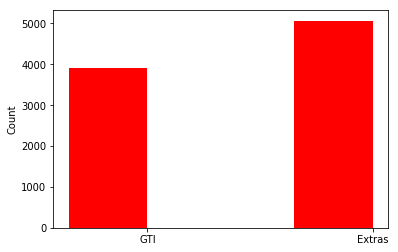

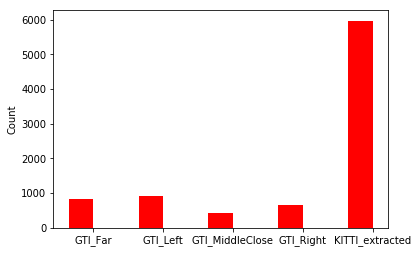

In [53]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

non_vehicle_paths = ['training_data/non-vehicles/non-vehicles/GTI/*.png',
                    'training_data/non-vehicles/non-vehicles/Extras/*.png']

vehicle_paths = ['training_data/vehicles/vehicles/GTI_Far/*.png',
                'training_data/vehicles/vehicles/GTI_Left/*.png',
                'training_data/vehicles/vehicles/GTI_MiddleClose/*.png',
                'training_data/vehicles/vehicles/GTI_Right/*.png',
                'training_data/vehicles/vehicles/KITTI_extracted/*.png',]

def image_array(path, color_space='BGR'):
    img_array = []
    images = glob.glob(path)
    for fname in images:
        img = cv2.imread(fname)
        if color_space != 'BGR':
            if color_space == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_array.append(img)
    return np.array(img_array)

def image_arrays_with_distribution(paths):
    array_of_image_arrays = []
    N = 0
    array_lengths = []
    folder_names = []
    for path in paths:
        folder_names.append(path.split('/')[-2])
        N += 1
        img_array = image_array(path, color_space='RGB')
        array_lengths.append(len(img_array))
        array_of_image_arrays.append(img_array)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots()
    rects = ax.bar(ind, array_lengths, width, color='r')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(folder_names)
    ax.set_ylabel('Count')
    return array_of_image_arrays

non_vehicles = image_arrays_with_distribution(non_vehicle_paths)
vehicles = image_arrays_with_distribution(vehicle_paths)

non_vehicles_np = np.concatenate(np.array(non_vehicles))
vehicles_np = np.concatenate(np.array(vehicles))

## Second, extract features

In [55]:
from skimage.feature import hog

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   feature_vector=feature_vec)
    return features

def extract_features(img_array, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in img_array:
        feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        # Return list of feature vectors
    return features

#Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

vehicle_features = extract_features(vehicles_np, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

non_vehicle_features = extract_features(non_vehicles_np, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


## Third, make data suitable for training

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Fourth, train the model

In [57]:
import time
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

23.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
0.00273 Seconds to predict 10 labels with SVC


## Fifth, slide windows and look for cars

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

img = cv2.imread(fname)


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))